In [17]:
import pandas as pd
import numpy as np

import seaborn as sns
import math
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import datetime
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as po

colors = ['red','orange','green','skyblue','blue','navy','purple','pink','olive','brown','gray','cyan','lightgreen','salmon','violet','orchid'
         ,'magenta','yellow','lime','limegreen','linen','maroon','mediumaquamarine','aquamarine','lawngreen']
EPS = [0.0001,0.0005,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.05,0.1,0.5]
plt.rc('font', family='Malgun Gothic')

In [2]:
path = "../../데이터분석 공모전/2021 공공빅데이터 공모전/cup_sharing/"

In [3]:
# from IPython.core.display import display, HTML
# ## 전체 구간을 넓게
# display(HTML("<style>.container { width:100% !important; }</style>"))
# ## 각 컬럼 width 최대로
# pd.set_option('display.max_colwidth', 40)
# ## columns
# pd.set_option('display.width', 1000)

# 상권 분석

* 상권 매출건수, 생활인구, 직장인구 정보 사용해서 어떤 상권을 고려하면 좋을지 분석.
* 자치구 컬럼이 있다면, 쓰레기 데이터와 묶어서 사용할 수 있을텐데 아쉬움.  - 묶을 수 있을까?

# 1. 데이터 준비
## 1)상권 매출, 생활인구, 직장인구 정보 합치기

In [18]:
comarea = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권영역).csv",encoding="cp949")
comarea_live = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권-생활인구).csv",encoding="cp949")
comarea_work = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권-직장인구).csv",encoding="cp949")
comarea_sales = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권-추정매출).csv",encoding="cp949")
around_comarea_live = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권배후지-상주인구).csv",encoding="cp949")
around_comarea_work = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권배후지-직장인구).csv",encoding="cp949")

In [19]:
comarea_sales['20_30_매출'] = comarea_sales['연령대_20_매출_건수']+comarea_sales['연령대_30_매출_건수']

In [20]:
cafe_sales = comarea_sales[['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드_명', '분기당_매출_금액', '분기당_매출_건수','20_30_매출', '점포수']]
cafe_sales = cafe_sales[cafe_sales['서비스_업종_코드_명'] == '커피-음료']

In [21]:
def whenColAdd(df, year_col,quarter_col):
    year_quarter = []
    for year,quarter in zip(df[year_col],df[quarter_col]):
         year_quarter.append(str(year)+" "+str(quarter)+"분기")
    df['when'] = year_quarter
    return df

cafe_sales = whenColAdd(cafe_sales,'기준_년_코드','기준_분기_코드')
comarea_live = whenColAdd(comarea_live,'기준 년코드','기준_분기_코드')
comarea_work = whenColAdd(comarea_work,'기준_년월_코드','기준_분기_코드')
around_comarea_live = whenColAdd(around_comarea_live,'기준_년_코드','기준_분기_코드')
around_comarea_work = whenColAdd(around_comarea_work,'기준_년_코드','기준_분기_코드')

In [22]:
def pplNumColAdd(cafe_df, ppl_df, when_col, code_col, pplnum_col):
    ppl_num = []
    for when,code in zip(cafe_df[when_col], cafe_df[code_col]):
        temp = ppl_df[ppl_df[code_col] == code]
        temp = temp[temp[when_col] == when]
        if len(temp) == 0 : #만약 2021 2분기 자료가 없는 경우, 다른 분기의 자료를 대신 사용하고자 함.
            temp = ppl_df[ppl_df[code_col] == code]
        ppl_num.append(temp[pplnum_col][temp[pplnum_col].index.values[0]])
    return ppl_num        
        
cafe_sales['총_생활인구_수'] = pplNumColAdd(cafe_sales, comarea_live, 'when', '상권_코드', '총_생활인구_수')
cafe_sales['총_직장인구_수'] = pplNumColAdd(cafe_sales, comarea_work, 'when', '상권_코드', '총_직장_인구_수')

# 배후지 데이터의 경우 약 700개의 지역에 대한 데이터가 없기 때문에 사용하지 않기로 함.
# cafe_sales['총_배후지_생활인구_수'] = pplNumColAdd(cafe_sales, around_comarea_live, 'when', '상권_코드', '총_상주인구_수')
# cafe_sales['총_배후지_직장인구_수'] = pplNumColAdd(cafe_sales, around_comarea_work, 'when', '상권_코드', '총_직장_인구_수')

In [23]:
cafe_sales[['상권_코드_명','분기당_매출_금액','분기당_매출_건수','점포수','when','총_생활인구_수','총_직장인구_수','20_30_매출']]

,상권_코드_명,분기당_매출_금액,분기당_매출_건수,점포수,when,총_생활인구_수,총_직장인구_수,20_30_매출
27,강남 마이스 관광특구,2053055072,286867,51,2021 2분기,95914,15904,165542
68,잠실 관광특구,6210528801,613766,92,2021 2분기,2998695,24375,385198
124,종로?청계 관광특구,5318572821,723493,140,2021 2분기,3889871,32935,437248
167,동대문패션타운 관광특구,2255021123,377729,92,2021 2분기,3164130,6054,243332
221,명동 남대문 북창동 다동 무교동 관광특구,16167991368,2161255,353,2021 2분기,3714818,104830,1169503
...,...,...,...,...,...,...,...,...
64663,백석동길,209323065,11913,6,2021 1분기,172515,1797,5564
64676,명륜길,5239004,1373,5,2021 1분기,626489,56,1120
64702,돈화문로11가길,217121362,37589,18,2021 1분기,162400,3686,18319
64720,난계로27길,131686750,15362,5,2021 1분기,320864,201,8668


In [24]:
cafe_sales_202102 = cafe_sales[cafe_sales['when']=='2021 2분기']

## 2)상권 위치 정보 추가

In [25]:
from pyproj import Proj, transform

proj_1 = Proj(init='epsg:5181')
proj_2 = Proj(init='epsg:4326')

converted = transform(proj_1, proj_2, comarea['엑스좌표_값'].values, comarea['와이좌표_값'].values)
comarea['longitude'] = converted[0]
comarea['latitude'] = converted[1]

C:\Users\Jihun\anaconda3\envs\chaconda\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Jihun\anaconda3\envs\chaconda\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-25-6baae18fed6b>:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  converted = 

In [26]:
longitude = []
latitude = []

for code in cafe_sales_202102['상권_코드']:
    temp = comarea[comarea['상권_코드'] == code]
    longitude.append(temp['longitude'][temp['longitude'].index.values[0]])
    latitude.append(temp['latitude'][temp['latitude'].index.values[0]])
    
cafe_sales_202102['longitude'] = longitude
cafe_sales_202102['latitude'] = latitude

## 3)상권 클러스터링 
* 너무 가까운 상권의 경우, 매출 건수와 인구를 합쳐서 고려하기위함

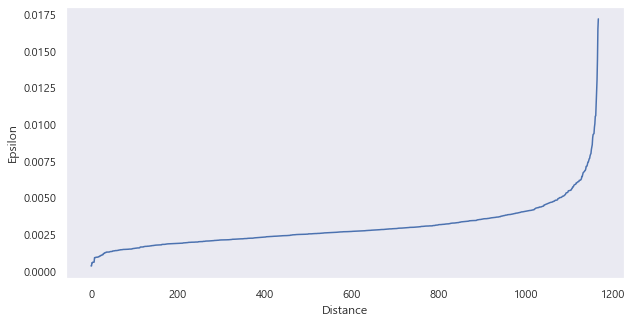

In [754]:
# we use nearestneighbors for calculating distance between points
from sklearn.neighbors import NearestNeighbors

X = comarea[['latitude','longitude']]

neigh=NearestNeighbors(n_neighbors=15)
distance=neigh.fit(X)
distances,indices=distance.kneighbors(X)
sorting_distances=np.sort(distances,axis=0)
# sorted_distances=sorting_distances[:,1]

fig, ax = plt.subplots(figsize=(10,5))
# plot between distance vs epsilon
plt.plot(sorted_distances)
plt.grid()
plt.xlabel("Distance")
plt.ylabel("Epsilon")
plt.show()

In [748]:
sorting_distances

array([[0.        , 0.00018056],
       [0.        , 0.00018056],
       [0.        , 0.00029164],
       ...,
       [0.        , 0.0144099 ],
       [0.        , 0.01646654],
       [0.        , 0.01716417]])

In [358]:
# dbscan clustering
EPS = [x/10000.0 for x in range(50,90)]
# EPS = [0.003 , 0.004, 0.005, 0.006, 0.007, 0.008]
MINS = [x for x in range(4,50)]

max_eps = 0
max_mins = 0 
max_sil = -100
pd.set_option('mode.chained_assignment',  None)

for EP in EPS:
    for MIN in MINS:
        db = DBSCAN(eps=EP, min_samples=MIN, metric='haversine')
        model=db.fit(cafe_sales_202102[['longitude','latitude']])
        if len(set(model.labels_))>2:
            cafe_sales_202102['dbscan'] = model.labels_.copy()
            score_samples = silhouette_samples(cafe_sales_202102[['longitude','latitude']],cafe_sales_202102['dbscan'])
            cafe_sales_202102['silhouette_coef'] = score_samples.copy()
            sils = cafe_sales_202102.groupby('dbscan')['silhouette_coef'].mean()
#             print(sils[1:].mean())
            sil = sils[1:].mean()
            if max_sil < sil:
                max_eps = EP
                max_mins = MIN
                max_sil = sil
print(max_eps)
print(max_mins)
print(max_sil)

0.0058
34
0.7629227545836537


In [359]:
# dbscan clustering
EPS = [x/10000.0 for x in range(50,90)]
# EPS = [0.003 , 0.004, 0.005, 0.006, 0.007, 0.008]
MINS = [x for x in range(4,50)]

max_eps = 0
max_mins = 0 
max_sil = -100
pd.set_option('mode.chained_assignment',  None)

for EP in EPS:
    for MIN in MINS:
        db = DBSCAN(eps=EP, min_samples=MIN, metric='euclidean')
        model=db.fit(cafe_sales_202102[['longitude','latitude']])
        if len(set(model.labels_))>2:
            cafe_sales_202102['dbscan'] = model.labels_.copy()
            score_samples = silhouette_samples(cafe_sales_202102[['longitude','latitude']],cafe_sales_202102['dbscan'])
            cafe_sales_202102['silhouette_coef'] = score_samples.copy()
            sils = cafe_sales_202102.groupby('dbscan')['silhouette_coef'].mean()
#             print(sils[1:].mean())
            sil = sils[1:].mean()
            if max_sil < sil:
                max_eps = EP
                max_mins = MIN
                max_sil = sil
print(max_eps)
print(max_mins)
print(max_sil)

0.005
10
0.9482241444427173


In [329]:
# dbscan clustering
EPS = [x/10000.0 for x in range(20,40)]
# EPS = [0.003 , 0.004, 0.005, 0.006, 0.007, 0.008]
MINS = [x for x in range(4,50)]

max_eps = 0
max_mins = 0 
max_sil = -100
pd.set_option('mode.chained_assignment',  None)

for EP in EPS:
    for MIN in MINS:
        db = DBSCAN(eps=EP, min_samples=MIN, metric='euclidean')
        model=db.fit(cafe_sales_202102[['longitude','latitude']])
        if len(set(model.labels_))>2:
            cafe_sales_202102['dbscan'] = model.labels_.copy()
            score_samples = silhouette_samples(cafe_sales_202102[['longitude','latitude']],cafe_sales_202102['dbscan'])
            cafe_sales_202102['silhouette_coef'] = score_samples.copy()
            sils = cafe_sales_202102.groupby('dbscan')['silhouette_coef'].mean()
#             print(sils[1:].mean())
            sil = sils[1:].mean()
            if max_sil < sil:
                max_eps = EP
                max_mins = MIN
                max_sil = sil
print(max_eps)
print(max_mins)
print(max_sil)

0.002
4
0.9789451110869293


In [773]:
db = DBSCAN(eps=0.002, min_samples=4, metric='haversine')
model=db.fit(cafe_sales_202102[['longitude','latitude']])
cafe_sales_202102['dbscan'] = model.labels_

score_samples = silhouette_samples(cafe_sales_202102[['longitude','latitude']],cafe_sales_202102['dbscan'])
cafe_sales_202102['silhouette_coef'] = score_samples.copy()
sils = cafe_sales_202102.groupby('dbscan')['silhouette_coef'].mean()
print(sils[1:].mean())

0.403296692443261


In [775]:
fig = px.scatter(cafe_sales_202102, 
                 title="cafe_sales_202102", 
                 x="longitude", 
                 y="latitude",
                 color = 'dbscan')
fig.show()

In [783]:
import folium
from folium import plugins

g_map = folium.Map(location=[37.5083, 127.0583], zoom_start=10)

In [784]:
temp = cafe_sales_202102[cafe_sales_202102['dbscan']==43]

In [785]:
for long,lat in zip(temp['longitude'],temp['latitude']):
    marker = folium.Marker([lat,long],icon=folium.Icon(color='blue'))
    marker.add_to(g_map)

In [786]:
g_map

In [725]:
df = pd.DataFrame([])
df['상권_코드_명'] =[]
df['분기당_매출_건수'] =[]
df['20_30_매출'] = []
df['점포수'] =[]
df['총_생활인구_수'] =[]
df['총_직장인구_수'] =[]
df['longitude'] =[]
df['latitude'] =[]

for index in range(0,len(set(cafe_sales_202102['dbscan']))-1):
    temp1 = cafe_sales_202102[['분기당_매출_건수','점포수','총_생활인구_수','총_직장인구_수','20_30_매출','dbscan']]
    temp2 = cafe_sales_202102[['상권_코드_명','longitude','latitude','dbscan']]
    temp2 = temp2[temp2['dbscan']==index]
    temp = temp1[temp1['dbscan']==index]
    temp = temp[['분기당_매출_건수','점포수','총_생활인구_수','총_직장인구_수','20_30_매출']].sum()
    temp['상권_코드_명'] = temp2['상권_코드_명'][temp2['상권_코드_명'].index.values[0]]
    temp['longitude'] = temp2['longitude'][temp2['longitude'].index.values[0]]
    temp['latitude'] = temp2['latitude'][temp2['latitude'].index.values[0]]
    df=df.append([temp])

In [726]:
df.reset_index(inplace=True,drop=True)

In [727]:
sales_result = cafe_sales_202102[cafe_sales_202102['dbscan']==-1]
sales_result = sales_result[['상권_코드_명','분기당_매출_건수','20_30_매출','점포수','총_생활인구_수','총_직장인구_수','longitude','latitude']]
cluster1_result = pd.concat([df,sales_result]).reset_index(drop=True)

cluster1_result

,상권_코드_명,분기당_매출_건수,20_30_매출,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude
0,동대문패션타운 관광특구,637312.0,405782.0,164.0,9466745.0,10966.0,127.011025,37.567312
1,명동 남대문 북창동 다동 무교동 관광특구,3686686.0,1984261.0,542.0,5059404.0,172521.0,126.981856,37.564149
2,길동복조리시장,598236.0,304815.0,215.0,28606766.0,11714.0,127.143675,37.538447
3,암사종합시장,739289.0,421437.0,242.0,19900216.0,21477.0,127.129134,37.550934
4,잠실 관광특구,753573.0,464046.0,121.0,6358907.0,29779.0,127.115275,37.516476
...,...,...,...,...,...,...,...,...
641,북촌로5나길,32721.0,19677.0,18.0,88947.0,234.0,126.983017,37.585791
642,북촌로5길,254755.0,162050.0,33.0,128077.0,503.0,126.981694,37.580349
643,북촌로11길,5178.0,2909.0,2.0,124660.0,671.0,126.984173,37.581313
644,백석동길,20760.0,9925.0,6.0,172958.0,1797.0,126.967762,37.597113


In [728]:
# cafe_sales_202102.to_csv(path+"clustered_comarea(nonclustered_ver)_0.88.csv")

In [729]:
# cluster1_result.to_csv(path+"clustered_comarea_0.88.csv")

# 2. 결과 확인
## 매출 건수가 높은, 생활인구, 직장인구 밀집 상권 확인

In [730]:
# ppl_cafe = result[['상권_코드_명','분기당_매출_건수','20_30_매출','점포수','총_생활인구_수','총_직장인구_수','longitude','latitude']].sort_values(['20_30_매출','총_직장인구_수'],ascending=False).head(20)
# ppl_cafe.head(20)

In [731]:
# fig, ax = plt.subplots(figsize=(15,15))

# cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
# ppl_cafe.plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
# for name,long,lat in zip(ppl_cafe['상권_코드_명'],ppl_cafe['longitude'],ppl_cafe['latitude']):
#         plt.text(long, lat, name, color = "blue", fontsize=9, weight='bold')

# 3. 가까운 상권 클러스터 후, 20_30_매출 & 직장인구 로 재 클러스터링

In [732]:
#직장인구를 직장인 가능 매출 건수로 고려.
data = cluster1_result.copy()
data["매출_중_2030매출비중"]=data["20_30_매출"]/data["분기당_매출_건수"]
data["매출_중_직장인가능비중"]=data["총_직장인구_수"]/data["분기당_매출_건수"]

data["점포_1개당_2030매출건수"]=data["20_30_매출"]/data["점포수"]
data["점포_1개당_직장인가능매출건수"]=data["총_직장인구_수"]/data["점포수"]

data["점포_1개당_2030매출비중"]=data["매출_중_2030매출비중"]/data["점포수"]
data["점포_1개당_직장인가능매출비중"]=data["매출_중_직장인가능비중"]/data["점포수"]
data['직장인구_생활인구'] = data['총_직장인구_수']/data['총_생활인구_수']

In [733]:
data_features = data[['분기당_매출_건수', '20_30_매출', '점포수','총_직장인구_수',
                '매출_중_2030매출비중', '매출_중_직장인가능비중','점포_1개당_2030매출건수',
                '점포_1개당_직장인가능매출건수', '점포_1개당_2030매출비중','점포_1개당_직장인가능매출비중','직장인구_생활인구']]
data_features = data_features.astype(float)
data.columns = ['Commercial_Area_Name', 'NumofSales', 'NumofSales_20_30', 
                'NumofStores', 'Total_Popluation', 'Total_Popluation_Worker', 
                'longitude', 'latitude','매출_중_2030매출비중', '매출_중_직장인가능비중','점포_1개당_2030매출건수',
                '점포_1개당_직장인가능매출건수', '점포_1개당_2030매출비중','점포_1개당_직장인가능매출비중','직장인구_생활인구']

In [734]:
# scale 후 clustering ...
#왜인지 모르게 scale이 안됨.

In [735]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data[["NumofSales_20_30",'Total_Popluation_Worker']])

#silhouette
data['kmeans'] = kmeans.labels_
sil_scores = silhouette_samples(data[['NumofSales_20_30','Total_Popluation_Worker']],data['kmeans'])
data['silhouette_coef'] = sil_scores.copy()
sil_mean = data.groupby('kmeans')['silhouette_coef'].mean()
print(sil_mean)
print("MEAN-->",sil_mean.mean())

kmeans
0    0.839545
1    0.808366
2    0.584274
3    0.365960
4    0.479065
Name: silhouette_coef, dtype: float64
MEAN--> 0.6154420751639363


<AxesSubplot:xlabel='NumofSales_20_30', ylabel='Total_Popluation_Worker'>

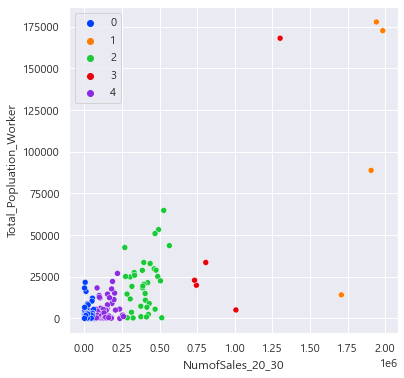

In [736]:
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='NumofSales_20_30', y='Total_Popluation_Worker',hue= kmeans.labels_,data=data[["NumofSales_20_30",'Total_Popluation_Worker']], palette='bright')

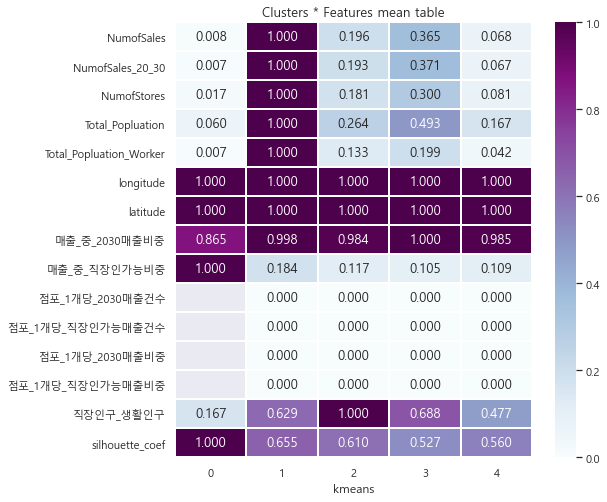

In [688]:
# 평균 데이터 테이블 만들기
temp = data.groupby(['kmeans']).mean()    # 클러스터,변수별 평균 구하기
cluster_mean = temp.transpose()    # x축 ↔ y축 전환 (변수들이 y 축으로 배치되게끔)
mean_table = cluster_mean.div(cluster_mean.max(axis=1), axis=0)    # 모든 변수의 최대값이 1, 최소값이 0이 되도록 데이터 스케일 조정

# 히트맵으로 그리기
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize = (8, 8))    # 히트맵 사이즈 설정
annot_kws= {'fontsize':13}    # 히트맵 폰트 사이즈 설정
sns.heatmap(mean_table,     # 히트맵 그릴 데이터셋
			annot=True,     # 레이블 표시 여부
            fmt='.3f',     # 레이블 표시 형식 (소숫점 3째자리까지)
            linewidths = 0.1,     # 히트맵 선 두께
            annot_kws = annot_kws,     # 아까 설정한 폰트 사이즈 적용
            cmap = 'BuPu')    # 컬러맵 설정
plt.title('Clusters * Features mean table', fontsize=13)
plt.show()

<AxesSubplot:xlabel='직장인구_생활인구', ylabel='kmeans'>

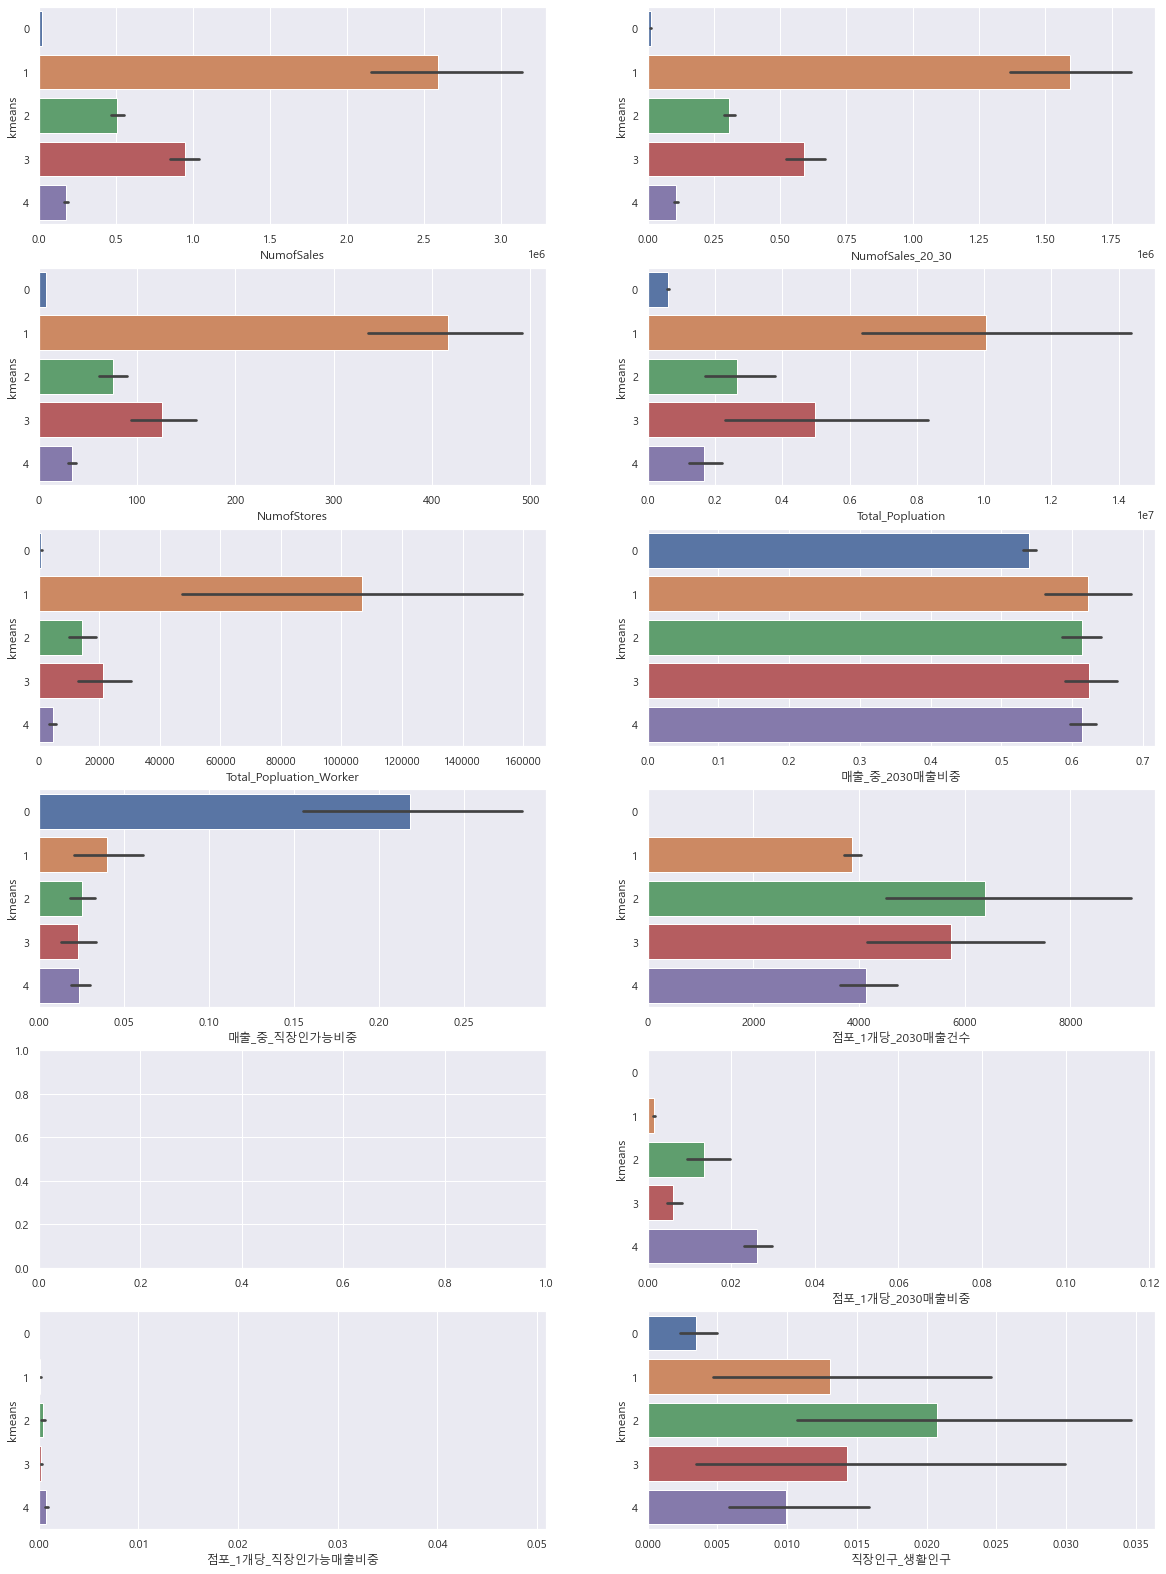

In [689]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11,ax12)) = plt.subplots(nrows=6, ncols=2) 
figure.set_size_inches(20, 28)   # 그래프 전체 사이즈 설정

sns.set_style('darkgrid')
sns.set(font='Malgun Gothic')
sns.barplot(data = data, y = 'kmeans', x = 'NumofSales', orient = 'h', ax = ax1)   # x축:값, y축:클러스터
sns.barplot(data = data, y = 'kmeans', x = 'NumofSales_20_30', orient = 'h', ax = ax2)
sns.barplot(data = data, y = 'kmeans', x = 'NumofStores', orient = 'h', ax = ax3)   # boxplot
sns.barplot(data = data, y = 'kmeans', x = 'Total_Popluation', orient = 'h', ax = ax4)
sns.barplot(data = data, y = 'kmeans', x = 'Total_Popluation_Worker', orient = 'h', ax = ax5)
sns.barplot(data = data, y = 'kmeans', x = '매출_중_2030매출비중', orient = 'h', ax = ax6)
sns.barplot(data = data, y = 'kmeans', x = '매출_중_직장인가능비중', orient = 'h', ax = ax7)
sns.barplot(data = data, y = 'kmeans', x = '점포_1개당_2030매출건수', orient = 'h', ax = ax8)
# sns.barplot(data = comarea_clustered, y = 'cluster', x = '직장인구수_점포', orient = 'h', ax = ax9)
sns.barplot(data = data, y = 'kmeans', x = '점포_1개당_2030매출비중', orient = 'h', ax = ax10)
sns.barplot(data = data, y = 'kmeans', x = '점포_1개당_직장인가능매출비중', orient = 'h', ax = ax11)
sns.barplot(data = data, y = 'kmeans', x = '직장인구_생활인구', orient = 'h', ax = ax12)

In [690]:
#label 0 
label = {0:[],1:[],2:[],3:[],4:[]}

for i in range(0,6):
    label[i] = data[data['kmeans']==i]

In [691]:
dbscan_label = {0:[],1:[],2:[],3:[],4:[],5:[]}

for name,dbscan in zip(cafe_sales_202102['상권_코드_명'],cafe_sales_202102['dbscan']):
    if name in set(label[0]['Commercial_Area_Name']):
        dbscan_label[0].append(dbscan)
    if name in set(label[1]['Commercial_Area_Name']):
        dbscan_label[1].append(dbscan)
    if name in set(label[2]['Commercial_Area_Name']):
        dbscan_label[2].append(dbscan)
    if name in set(label[3]['Commercial_Area_Name']):
        dbscan_label[3].append(dbscan)
    if name in set(label[4]['Commercial_Area_Name']):
        dbscan_label[4].append(dbscan)

In [692]:
print(label[0]['NumofStores'].mean(),": min - ",label[0]['NumofStores'].min(),":max - ",label[0]['NumofStores'].max())
print(label[1]['NumofStores'].mean(),": min - ",label[1]['NumofStores'].min(),":max - ",label[1]['NumofStores'].max())
print(label[2]['NumofStores'].mean(),": min - ",label[2]['NumofStores'].min(),":max - ",label[2]['NumofStores'].max())
print(label[3]['NumofStores'].mean(),": min - ",label[3]['NumofStores'].min(),":max - ",label[3]['NumofStores'].max())
print(label[4]['NumofStores'].mean(),": min - ",label[4]['NumofStores'].min(),":max - ",label[4]['NumofStores'].max())

7.198813056379822 : min -  0.0 :max -  51.0
416.0 : min -  278.0 :max -  535.0
75.19444444444444 : min -  7.0 :max -  201.0
124.9 : min -  45.0 :max -  199.0
33.70967741935484 : min -  8.0 :max -  110.0


### Label 0:
* 점포수: 평균 85 ( 7 – 242)
* 전체 매출 대비 2030의 매출 비율이 높고 (2위)
* 점포 수를 고려하면 2030의 매출 비율이 가장 높은 지역.
* 이대, 신촌, 노량진, 시청, 명동, 이태원, 역삼 등


In [693]:
# #label 0 
# label_name_index = label[0]['Commercial_Area_Name'][label[0]['Commercial_Area_Name'].index[0]]
# label[0].head(10)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

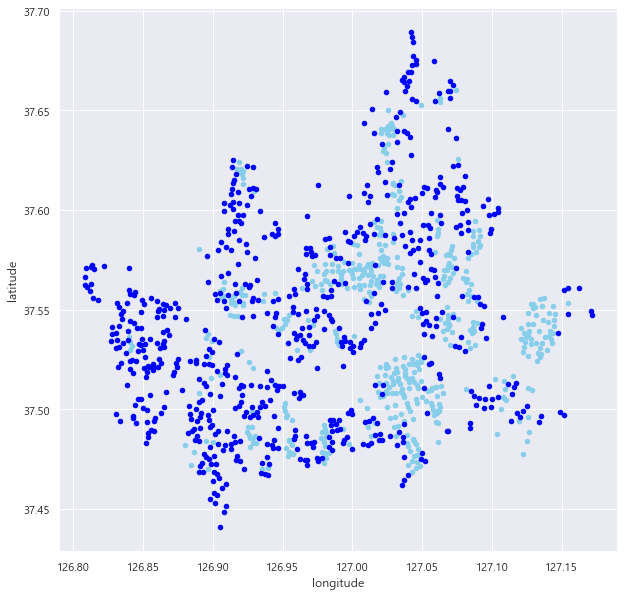

In [694]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[0].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
# for name,long,lat in zip(label[0]['Commercial_Area_Name'],label[0]['longitude'],label[0]['latitude']):
#         plt.text(long, lat, name, color = "blue", fontsize=12, weight='bold')

### label 1
* 점포수 300 이상 550 이하
* 총 매출건수, 직장인구가 가장 높은 상권들. 
* 생활인구 대비 직장인구의 비율 또한 다른 상권들보다 높은 경향을 보인다. = 직장인의 매출이 높을 것으로 예상됨.
* 초 발달상권으로 분류

In [695]:
#label 1
label[1].head(10)

,Commercial_Area_Name,NumofSales,NumofSales_20_30,NumofStores,Total_Popluation,Total_Popluation_Worker,longitude,latitude,매출_중_2030매출비중,매출_중_직장인가능비중,점포_1개당_2030매출건수,점포_1개당_직장인가능매출건수,점포_1개당_2030매출비중,점포_1개당_직장인가능매출비중,직장인구_생활인구,kmeans,silhouette_coef
3,영동전통시장,2145199.0,1413501.0,365.0,10641639.0,47498.0,127.024182,37.509178,0.658914,0.022142,3872.605479,130.131507,0.001805,0.000061,0.004463,1,0.560299
21,명동 남대문 북창동 다동 무교동 관광특구,3660209.0,1968159.0,535.0,4911985.0,172341.0,126.981856,37.564149,0.537718,0.047085,3678.801869,322.132710,0.001005,0.000088,0.035086,1,0.652278
23,서교시장,2273037.0,1666961.0,426.0,6443712.0,12276.0,126.921539,37.553393,0.733363,0.005401,3913.053991,28.816901,0.001722,0.000013,0.001905,1,0.702814
25,압구정 로데오거리_2,2788080.0,1753460.0,476.0,18733924.0,150355.0,127.037197,37.526113,0.628913,0.053928,3683.739496,315.871849,0.001321,0.000113,0.008026,1,0.717765
29,강남 마이스 관광특구,2109538.0,1167078.0,278.0,9576541.0,151570.0,127.060059,37.511003,0.553239,0.071850,4198.122302,545.215827,0.001990,0.000258,0.015827,1,0.080910


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

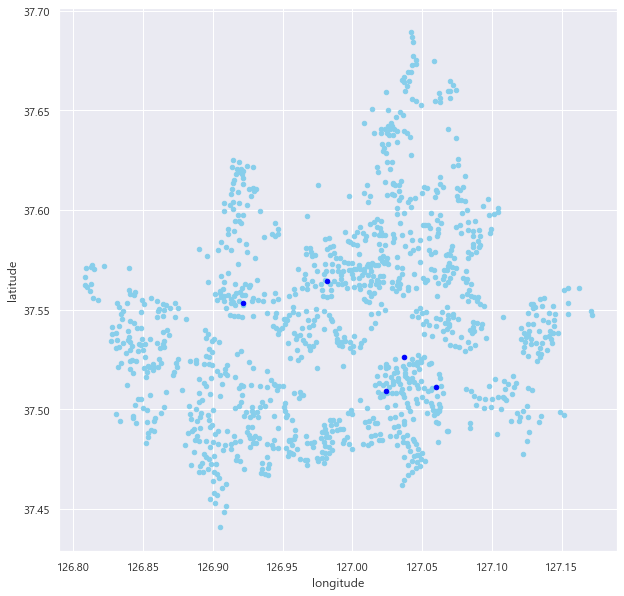

In [696]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[1].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
# for name,long,lat in zip(label[1]['Commercial_Area_Name'],label[1]['longitude'],label[1]['latitude']):
#         plt.text(long, lat, name, color = "blue", fontsize=8, weight='bold')

### label 2
* 점포수 250 미만
* 전체 매출 대비 2030의 매출 비율이 높고, 점포 수를 고려하면 가장 높은 지역임.
* 이대, 신촌, 노량진, 시청, 명동, 이태원, 역삼 등

In [697]:
#label 2
label_name_index = label[2]['Commercial_Area_Name'][label[2]['Commercial_Area_Name'].index[2]]
label[2].head(20)

,Commercial_Area_Name,NumofSales,NumofSales_20_30,NumofStores,Total_Popluation,Total_Popluation_Worker,longitude,latitude,매출_중_2030매출비중,매출_중_직장인가능비중,점포_1개당_2030매출건수,점포_1개당_직장인가능매출건수,점포_1개당_2030매출비중,점포_1개당_직장인가능매출비중,직장인구_생활인구,kmeans,silhouette_coef
2,암사종합시장,632437.0,369664.0,201.0,15690575.0,15103.0,127.129134,37.550934,0.584507,0.023881,1839.124378,75.139303,0.002908,0.000119,0.000963,2,0.625327
8,강북종합시장,375025.0,229946.0,107.0,10464517.0,4884.0,127.025698,37.642326,0.613148,0.013023,2149.028037,45.644860,0.005730,0.000122,0.000467,2,0.322680
14,능동로골목시장,547741.0,422759.0,116.0,7351262.0,2180.0,127.066743,37.535110,0.771823,0.003980,3644.474138,18.793103,0.006654,0.000034,0.000297,2,0.286783
17,동대문패션타운 관광특구,637312.0,405782.0,164.0,9466745.0,10966.0,127.011025,37.567312,0.636709,0.017207,2474.280488,66.865854,0.003882,0.000105,0.001158,2,0.427705
19,평화시장,392012.0,230609.0,117.0,3447476.0,17083.0,127.008037,37.568871,0.588270,0.043578,1971.017094,146.008547,0.005028,0.000372,0.004955,2,0.329718
27,강남구 신사역_1,383288.0,226782.0,77.0,4491787.0,8970.0,127.017442,37.516477,0.591675,0.023403,2945.220779,116.493506,0.007684,0.000304,0.001997,2,0.286979
31,매봉역,677426.0,339051.0,137.0,7394828.0,50730.0,127.043486,37.485106,0.500499,0.074886,2474.824818,370.291971,0.003653,0.000547,0.006860,2,0.669891
34,보라매공원,366944.0,212162.0,46.0,3356045.0,3280.0,126.925042,37.491172,0.578186,0.008939,4612.217391,71.304348,0.012569,0.000194,0.000977,2,0.060857
36,영진시장,322145.0,241710.0,61.0,2371823.0,5236.0,126.912848,37.553423,0.750314,0.016254,3962.459016,85.836066,0.012300,0.000266,0.002208,2,0.439301
42,잠실 관광특구,613766.0,385198.0,92.0,2998695.0,24375.0,127.115275,37.516476,0.627597,0.039714,4186.934783,264.945652,0.006822,0.000432,0.008129,2,0.551865


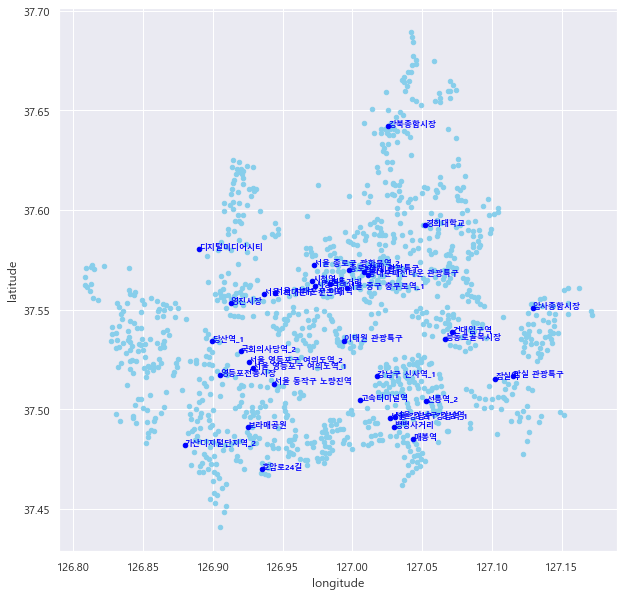

In [698]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[2].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
for name,long,lat in zip(label[2]['Commercial_Area_Name'],label[2]['longitude'],label[2]['latitude']):
        plt.text(long, lat, name, color = "blue", fontsize=8, weight='bold')

### label 3
* 점포수 400 이상 600 이하
* 2030의 매출 총 건수와 총 점포 수가 가장 높고, 총 매출 대비 2030의 매출도 가장 높음.
* 유동인구가 가장 많은 지역.
* 압구정역, 가로수길, 홍대

In [699]:
label[3].head(20)

,Commercial_Area_Name,NumofSales,NumofSales_20_30,NumofStores,Total_Popluation,Total_Popluation_Worker,longitude,latitude,매출_중_2030매출비중,매출_중_직장인가능비중,점포_1개당_2030매출건수,점포_1개당_직장인가능매출건수,점포_1개당_2030매출비중,점포_1개당_직장인가능매출비중,직장인구_생활인구,kmeans,silhouette_coef
5,남성사계시장,760132.0,466031.0,100.0,8097963.0,5210.0,126.980834,37.488230,0.613092,0.006854,4660.310000,52.100000,0.006131,0.000069,0.000643,3,0.099785
16,서울중앙시장,768232.0,477288.0,193.0,15705687.0,24666.0,127.019639,37.566960,0.621281,0.032107,2472.994819,127.803109,0.003219,0.000166,0.001571,3,0.226024
22,서울 종로구 종로3가역_3,1206063.0,617358.0,196.0,3313007.0,29863.0,126.993921,37.573737,0.511879,0.024761,3149.785714,152.362245,0.002612,0.000126,0.009014,3,0.601672
26,서울 강남구 압구정역,836020.0,493085.0,199.0,9600148.0,41281.0,127.030578,37.525079,0.589800,0.049378,2477.814070,207.442211,0.002964,0.000248,0.004300,3,0.332835
30,서울 관악구 신림역_4,1066681.0,795536.0,88.0,5835747.0,1825.0,126.930214,37.486436,0.745805,0.001711,9040.181818,20.738636,0.008475,0.000019,0.000313,3,0.531747
107,서울 노원구 노원역_3,883079.0,515002.0,45.0,1221690.0,418.0,127.062511,37.656016,0.583189,0.000473,11444.488889,9.288889,0.012960,0.000011,0.000342,3,0.432251
199,서울 서초구 강남역,1055649.0,744788.0,147.0,2770777.0,19954.0,127.030546,37.502031,0.705526,0.018902,5066.585034,135.741497,0.004799,0.000129,0.007202,3,0.582692
204,서울 강남구 역삼역_1,822632.0,506070.0,81.0,1858272.0,22546.0,127.035136,37.497561,0.615184,0.027407,6247.777778,278.345679,0.007595,0.000338,0.012133,3,0.415724
229,구로디지탈1단지,902524.0,565115.0,90.0,633822.0,43655.0,126.895087,37.483806,0.626150,0.048370,6279.055556,485.055556,0.006957,0.000537,0.068876,3,0.557397
235,가산디지털단지역_3,1168796.0,732664.0,110.0,595075.0,22935.0,126.886434,37.478437,0.626854,0.019623,6660.581818,208.500000,0.005699,0.000178,0.038541,3,0.589814


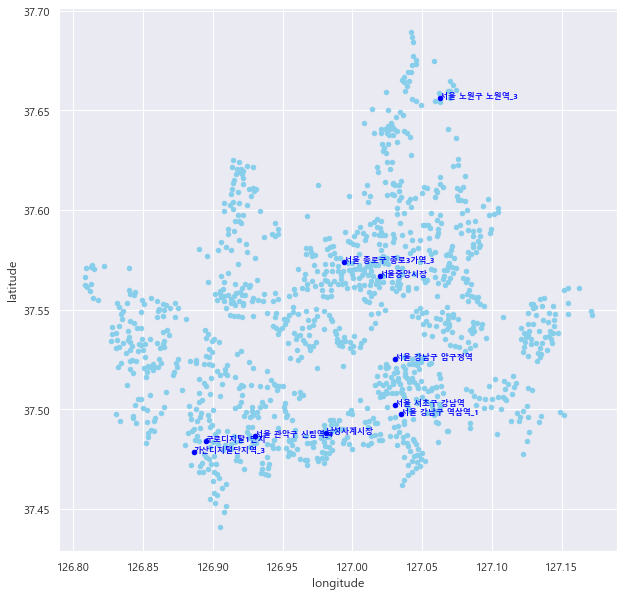

In [700]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[3].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
for name,long,lat in zip(label[3]['Commercial_Area_Name'],label[3]['longitude'],label[3]['latitude']):
        plt.text(long, lat, name, color = "blue", fontsize=8, weight='bold')

### label 4
* 점포수 300 이하
* 점포 수를 고려한 2030 매출이 꽤 있는 지역. (2위)
* 유동인구 대비, 직장인구가 가장 많은 지역
* 구디, 가디, 여의도, 시청, 종로, 역삼

In [701]:
label[4].head(20)

,Commercial_Area_Name,NumofSales,NumofSales_20_30,NumofStores,Total_Popluation,Total_Popluation_Worker,longitude,latitude,매출_중_2030매출비중,매출_중_직장인가능비중,점포_1개당_2030매출건수,점포_1개당_직장인가능매출건수,점포_1개당_2030매출비중,점포_1개당_직장인가능매출비중,직장인구_생활인구,kmeans,silhouette_coef
0,길동복조리시장,386169.0,194935.0,110.0,15491562.0,7066.0,127.143675,37.538447,0.504792,0.018298,1772.136364,64.236364,0.004589,0.000166,0.000456,4,0.205668
1,둔촌역전통시장,212067.0,109880.0,105.0,13115204.0,4648.0,127.135464,37.527726,0.518138,0.021918,1046.476190,44.266667,0.004935,0.000209,0.000354,4,0.653298
4,봉천중앙시장,103026.0,75078.0,55.0,4396811.0,2290.0,126.954468,37.484304,0.728729,0.022227,1365.054545,41.636364,0.013250,0.000404,0.000521,4,0.415488
6,상도전통시장,111403.0,62699.0,31.0,2848602.0,1301.0,126.952118,37.499160,0.562812,0.011678,2022.548387,41.967742,0.018155,0.000377,0.000457,4,0.120497
7,공덕시장,204248.0,104330.0,46.0,1714052.0,12291.0,126.952904,37.544535,0.510801,0.060177,2268.043478,267.195652,0.011104,0.001308,0.007171,4,0.628372
9,숭인시장,170115.0,97423.0,44.0,1177765.0,836.0,127.029255,37.613539,0.572689,0.004914,2214.159091,19.000000,0.013016,0.000112,0.000710,4,0.610424
10,사가정시장,124979.0,72944.0,26.0,4382862.0,1527.0,127.090445,37.581261,0.583650,0.012218,2805.538462,58.730769,0.022448,0.000470,0.000348,4,0.378336
11,면목골목시장,98686.0,59662.0,34.0,5546107.0,1104.0,127.084838,37.577905,0.604564,0.011187,1754.764706,32.470588,0.017781,0.000329,0.000199,4,0.006327
12,전곡시장,299006.0,161887.0,98.0,8630724.0,6606.0,127.068830,37.578087,0.541417,0.022093,1651.908163,67.408163,0.005525,0.000225,0.000765,4,0.584227
13,중곡제일시장,93811.0,61171.0,70.0,6832092.0,3983.0,127.081222,37.563816,0.652066,0.042458,873.871429,56.900000,0.009315,0.000607,0.000583,4,0.067453


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

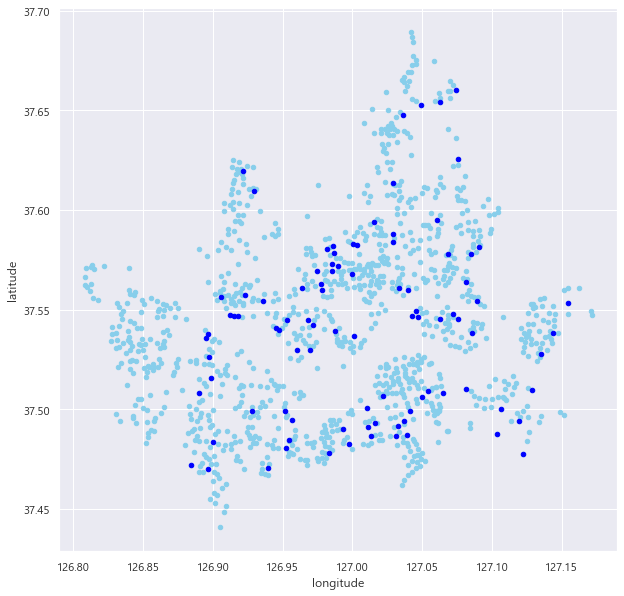

In [702]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[4].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
# for name,long,lat in zip(label[4]['Commercial_Area_Name'],label[4]['longitude'],label[4]['latitude']):
#         plt.text(long, lat, name, color = "blue", fontsize=8, weight='bold')

# -----------------------------------------

### 상은님이 주신 결과로 분석 진행.

In [51]:
comarea_clustered = pd.read_csv(path+"cafe_road_v2_csv.csv")
comarea_clustered.columns = ['Commercial_Area_Name', 'NumofSales', 'NumofSales_20_30', 
                             'NumofStores', 'Total_Popluation', 'Total_Popluation_Worker', 
                             'longitude', 'latitude', "cluster"]

In [52]:
#직장인구를 직장인 가능 매출 건수로 고려.
comarea_clustered["매출_중_2030매출비중"]=comarea_clustered["NumofSales_20_30"]/comarea_clustered["NumofSales"]
comarea_clustered["매출_중_직장인가능비중"]=comarea_clustered["Total_Popluation_Worker"]/comarea_clustered["NumofSales"]
comarea_clustered["점포_1개당_2030매출건수"]=comarea_clustered["NumofSales_20_30"]/comarea_clustered["NumofStores"]
comarea_clustered["점포_1개당_직장인가능매출건수"]=comarea_clustered["Total_Popluation_Worker"]/comarea_clustered["NumofStores"]

comarea_clustered["점포_1개당_2030매출비중"]=comarea_clustered["매출_중_2030매출비중"]/comarea_clustered["NumofStores"]
comarea_clustered["점포_1개당_직장인가능매출비중"]=comarea_clustered["매출_중_직장인가능비중"]/comarea_clustered["NumofStores"]

In [53]:
comarea_clustered['직장인구_생활인구'] = comarea_clustered['Total_Popluation_Worker']/comarea_clustered['Total_Popluation']

<AxesSubplot:xlabel='NumofSales_20_30', ylabel='Total_Popluation_Worker'>

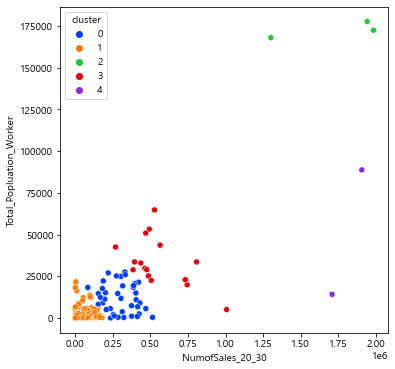

In [54]:
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='NumofSales_20_30', y='Total_Popluation_Worker',hue= comarea_clustered['cluster'],data=comarea_clustered[["NumofSales_20_30",'Total_Popluation_Worker']], palette='bright')

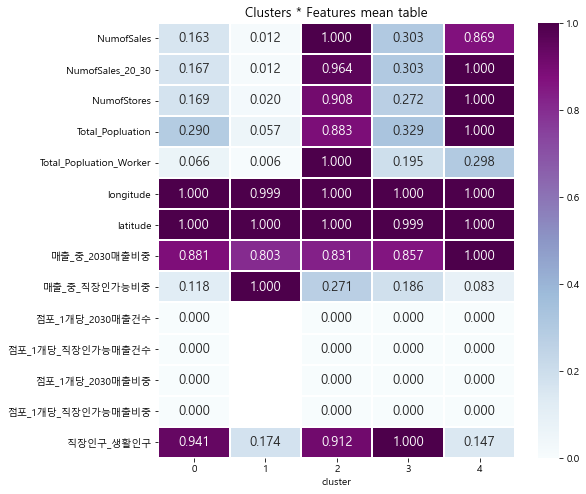

In [55]:
# 평균 데이터 테이블 만들기
temp = comarea_clustered.groupby(['cluster']).mean()    # 클러스터,변수별 평균 구하기
cluster_mean = temp.transpose()    # x축 ↔ y축 전환 (변수들이 y 축으로 배치되게끔)
mean_table = cluster_mean.div(cluster_mean.max(axis=1), axis=0)    # 모든 변수의 최대값이 1, 최소값이 0이 되도록 데이터 스케일 조정

# 히트맵으로 그리기
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize = (8, 8))    # 히트맵 사이즈 설정
annot_kws= {'fontsize':13}    # 히트맵 폰트 사이즈 설정
sns.heatmap(mean_table,     # 히트맵 그릴 데이터셋
			annot=True,     # 레이블 표시 여부
            fmt='.3f',     # 레이블 표시 형식 (소숫점 3째자리까지)
            linewidths = 0.1,     # 히트맵 선 두께
            annot_kws = annot_kws,     # 아까 설정한 폰트 사이즈 적용
            cmap = 'BuPu')    # 컬러맵 설정
plt.title('Clusters * Features mean table', fontsize=13)
plt.show()

<AxesSubplot:xlabel='직장인구_생활인구', ylabel='cluster'>

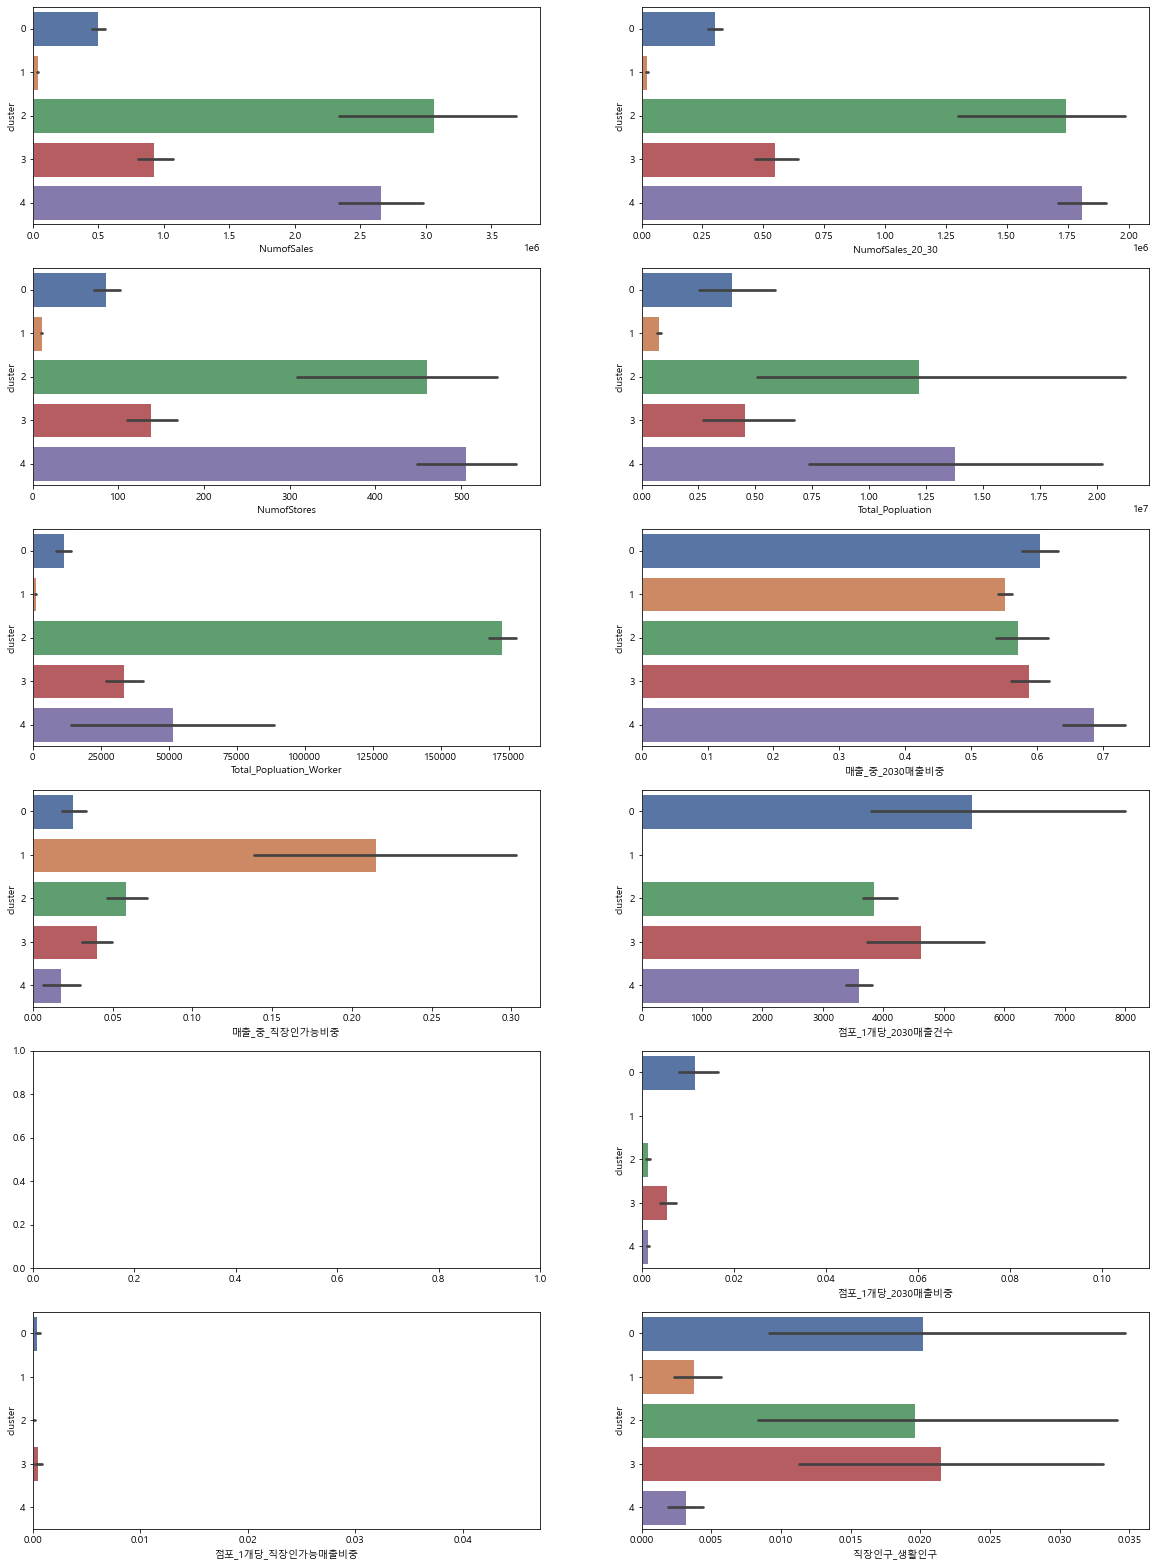

In [56]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11,ax12)) = plt.subplots(nrows=6, ncols=2) 
figure.set_size_inches(20, 28)   # 그래프 전체 사이즈 설정

sns.set_style('darkgrid')
sns.set(font='Malgun Gothic')
sns.barplot(data = comarea_clustered, y = 'cluster', x = 'NumofSales', orient = 'h', ax = ax1)   # x축:값, y축:클러스터
sns.barplot(data = comarea_clustered, y = 'cluster', x = 'NumofSales_20_30', orient = 'h', ax = ax2)
sns.barplot(data = comarea_clustered, y = 'cluster', x = 'NumofStores', orient = 'h', ax = ax3)   # boxplot
sns.barplot(data = comarea_clustered, y = 'cluster', x = 'Total_Popluation', orient = 'h', ax = ax4)
sns.barplot(data = comarea_clustered, y = 'cluster', x = 'Total_Popluation_Worker', orient = 'h', ax = ax5)
sns.barplot(data = comarea_clustered, y = 'cluster', x = '매출_중_2030매출비중', orient = 'h', ax = ax6)
sns.barplot(data = comarea_clustered, y = 'cluster', x = '매출_중_직장인가능비중', orient = 'h', ax = ax7)
sns.barplot(data = comarea_clustered, y = 'cluster', x = '점포_1개당_2030매출건수', orient = 'h', ax = ax8)
# sns.barplot(data = comarea_clustered, y = 'cluster', x = '직장인구수_점포', orient = 'h', ax = ax9)
sns.barplot(data = comarea_clustered, y = 'cluster', x = '점포_1개당_2030매출비중', orient = 'h', ax = ax10)
sns.barplot(data = comarea_clustered, y = 'cluster', x = '점포_1개당_직장인가능매출비중', orient = 'h', ax = ax11)
sns.barplot(data = comarea_clustered, y = 'cluster', x = '직장인구_생활인구', orient = 'h', ax = ax12)

In [59]:
#label 0 
label = {0:[],1:[],2:[],3:[],4:[],5:[]}

for i in range(0,6):
    label[i] = comarea_clustered[comarea_clustered['cluster']==i]

In [60]:
dbscan_label = {0:[],1:[],2:[],3:[],4:[],5:[]}

for name,dbscan in zip(cafe_sales_202102['상권_코드_명'],cafe_sales_202102['dbscan']):
    if name in set(label[0]['Commercial_Area_Name']):
        dbscan_label[0].append(dbscan)
    if name in set(label[1]['Commercial_Area_Name']):
        dbscan_label[1].append(dbscan)
    if name in set(label[2]['Commercial_Area_Name']):
        dbscan_label[2].append(dbscan)
    if name in set(label[3]['Commercial_Area_Name']):
        dbscan_label[3].append(dbscan)
    if name in set(label[4]['Commercial_Area_Name']):
        dbscan_label[4].append(dbscan)
    if name in set(label[5]['Commercial_Area_Name']):
        dbscan_label[5].append(dbscan)

In [61]:
print(label[0]['NumofStores'].mean(),": min - ",label[0]['NumofStores'].min(),":max - ",label[0]['NumofStores'].max())
print(label[1]['NumofStores'].mean(),": min - ",label[1]['NumofStores'].min(),":max - ",label[1]['NumofStores'].max())
print(label[2]['NumofStores'].mean(),": min - ",label[2]['NumofStores'].min(),":max - ",label[2]['NumofStores'].max())
print(label[3]['NumofStores'].mean(),": min - ",label[3]['NumofStores'].min(),":max - ",label[3]['NumofStores'].max())
print(label[4]['NumofStores'].mean(),": min - ",label[4]['NumofStores'].min(),":max - ",label[4]['NumofStores'].max())

85.65853658536585 : min -  7 :max -  242
10.128424657534246 : min -  0 :max -  124
459.6666666666667 : min -  308 :max -  542
137.8125 : min -  30 :max -  277
506.0 : min -  448 :max -  564


### Label 0:
* 점포수: 평균 85 ( 7 – 242)
* 전체 매출 대비 2030의 매출 비율이 높고 (2위)
* 점포 수를 고려하면 2030의 매출 비율이 가장 높은 지역.
* 이대, 신촌, 노량진, 시청, 명동, 이태원, 역삼 등


In [62]:
#label 0 
label_name_index = label[0]['Commercial_Area_Name'][label[0]['Commercial_Area_Name'].index[0]]
label[0].head(10)

,Commercial_Area_Name,NumofSales,NumofSales_20_30,NumofStores,Total_Popluation,Total_Popluation_Worker,longitude,latitude,cluster,매출_중_2030매출비중,매출_중_직장인가능비중,점포_1개당_2030매출건수,점포_1개당_직장인가능매출건수,점포_1개당_2030매출비중,점포_1개당_직장인가능매출비중,직장인구_생활인구
0,동대문패션타운 관광특구,637312,405782,164,9466745,10966,127.011025,37.567312,0,0.636709,0.017207,2474.280488,66.865854,0.003882,0.000105,0.001158
2,길동복조리시장,598236,304815,215,28606766,11714,127.143675,37.538447,0,0.509523,0.019581,1417.744186,54.483721,0.002370,0.000091,0.000409
3,암사종합시장,739289,421437,242,19900216,21477,127.129134,37.550934,0,0.570057,0.029051,1741.475207,88.747934,0.002356,0.000120,0.001079
7,남성사계시장,767464,470171,104,8878220,5582,126.980834,37.488230,0,0.612629,0.007273,4520.875000,53.673077,0.005891,0.000070,0.000629
13,영진시장,580452,430990,116,4751225,8995,126.912848,37.553423,0,0.742508,0.015497,3715.431034,77.543103,0.006401,0.000134,0.001893
17,강북종합시장,384232,233973,123,13756903,5622,127.025698,37.642326,0,0.608937,0.014632,1902.219512,45.707317,0.004951,0.000119,0.000409
24,회기시장,542980,376000,81,6148924,1069,127.055572,37.591113,0,0.692475,0.001969,4641.975309,13.197531,0.008549,0.000024,0.000174
25,전곡시장,339592,183598,106,9469058,9042,127.068830,37.578087,0,0.540643,0.026626,1732.056604,85.301887,0.005100,0.000251,0.000955
26,능동로골목시장,553491,425654,119,8153436,2471,127.066743,37.535110,0,0.769035,0.004464,3576.924370,20.764706,0.006462,0.000038,0.000303
30,방산종합시장,386586,187266,76,3118895,22211,127.000124,37.568033,0,0.484410,0.057454,2464.026316,292.250000,0.006374,0.000756,0.007121


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

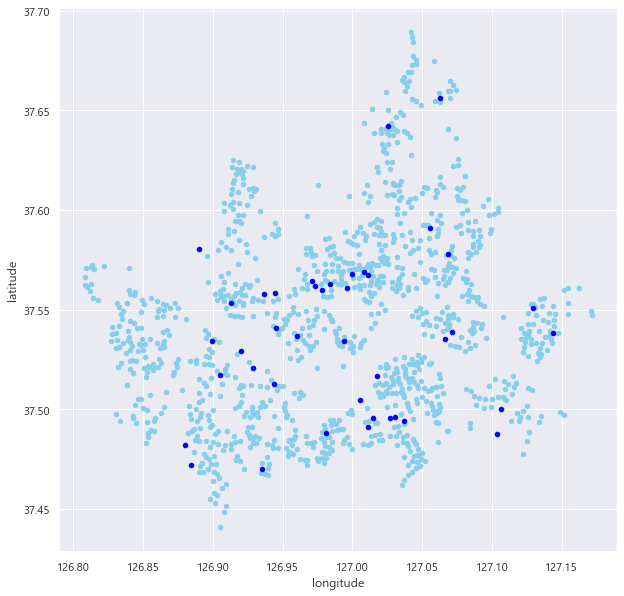

In [68]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[0].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
# for name,long,lat in zip(label[0]['Commercial_Area_Name'],label[0]['longitude'],label[0]['latitude']):
#         plt.text(long, lat, name, color = "blue", fontsize=12, weight='bold')

### label 1
* 점포수 300 이상 550 이하
* 총 매출건수, 직장인구가 가장 높은 상권들. 
* 생활인구 대비 직장인구의 비율 또한 다른 상권들보다 높은 경향을 보인다. = 직장인의 매출이 높을 것으로 예상됨.
* 초 발달상권으로 분류

In [64]:
#label 1
label[1].head(10)

,Commercial_Area_Name,NumofSales,NumofSales_20_30,NumofStores,Total_Popluation,Total_Popluation_Worker,longitude,latitude,cluster,매출_중_2030매출비중,매출_중_직장인가능비중,점포_1개당_2030매출건수,점포_1개당_직장인가능매출건수,점포_1개당_2030매출비중,점포_1개당_직장인가능매출비중,직장인구_생활인구
6,봉천중앙시장,103026,75078,55,4396811,2290,126.954468,37.484304,1,0.728729,0.022227,1365.054545,41.636364,0.013250,0.000404,0.000521
8,흑석시장,21215,10111,18,760229,224,126.963344,37.507291,1,0.476597,0.010559,561.722222,12.444444,0.026478,0.000587,0.000295
9,상도전통시장,111403,62699,31,2848602,1301,126.952118,37.499160,1,0.562812,0.011678,2022.548387,41.967742,0.018155,0.000377,0.000457
10,화곡중앙골목시장,33025,18626,20,4036426,1293,126.839146,37.534560,1,0.563997,0.039152,931.300000,64.650000,0.028200,0.001958,0.000320
11,신정3동골목시장,78764,41248,10,704860,286,126.853003,37.518720,1,0.523691,0.003631,4124.800000,28.600000,0.052369,0.000363,0.000406
12,망원월드컵시장,172542,103021,61,3650957,2200,126.905406,37.558130,1,0.597078,0.012751,1688.868852,36.065574,0.009788,0.000209,0.000603
14,공덕시장,204248,104330,46,1714052,12291,126.952904,37.544535,1,0.510801,0.060177,2268.043478,267.195652,0.011104,0.001308,0.007171
15,연서시장,204199,122717,68,6307371,2018,126.921673,37.619571,1,0.600968,0.009883,1804.661765,29.676471,0.008838,0.000145,0.000320
16,상계중앙시장,6534,2644,22,5590623,632,127.069994,37.659778,1,0.404653,0.096725,120.181818,28.727273,0.018393,0.004397,0.000113
18,숭인시장,170115,97423,44,1177765,836,127.029255,37.613539,1,0.572689,0.004914,2214.159091,19.000000,0.013016,0.000112,0.000710


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

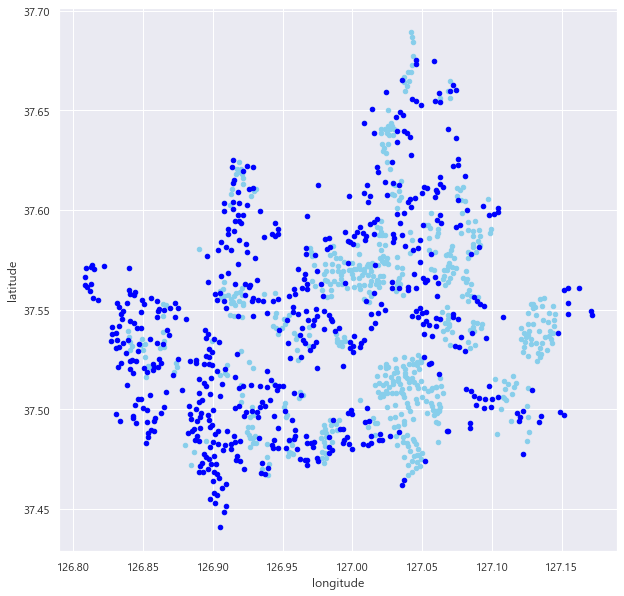

In [65]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[1].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
# for name,long,lat in zip(label[1]['Commercial_Area_Name'],label[1]['longitude'],label[1]['latitude']):
#         plt.text(long, lat, name, color = "blue", fontsize=8, weight='bold')

### label 2
* 점포수 250 미만
* 전체 매출 대비 2030의 매출 비율이 높고, 점포 수를 고려하면 가장 높은 지역임.
* 이대, 신촌, 노량진, 시청, 명동, 이태원, 역삼 등

In [66]:
#label 2
label_name_index = label[2]['Commercial_Area_Name'][label[2]['Commercial_Area_Name'].index[2]]
label[2].head(20)

,Commercial_Area_Name,NumofSales,NumofSales_20_30,NumofStores,Total_Popluation,Total_Popluation_Worker,longitude,latitude,cluster,매출_중_2030매출비중,매출_중_직장인가능비중,점포_1개당_2030매출건수,점포_1개당_직장인가능매출건수,점포_1개당_2030매출비중,점포_1개당_직장인가능매출비중,직장인구_생활인구
1,명동 남대문 북창동 다동 무교동 관광특구,3686686,1984261,542,5059404,172521,126.981856,37.564149,2,0.538223,0.046796,3660.998155,318.304428,0.000993,0.000086,0.034099
43,압구정 로데오거리_2,3150080,1941826,529,21237868,177737,127.037197,37.526113,2,0.616437,0.056423,3670.748582,335.986767,0.001165,0.000107,0.008369
47,강남 마이스 관광특구,2338126,1301632,308,10270165,167999,127.060059,37.511003,2,0.556699,0.071852,4226.077922,545.451299,0.001807,0.000233,0.016358


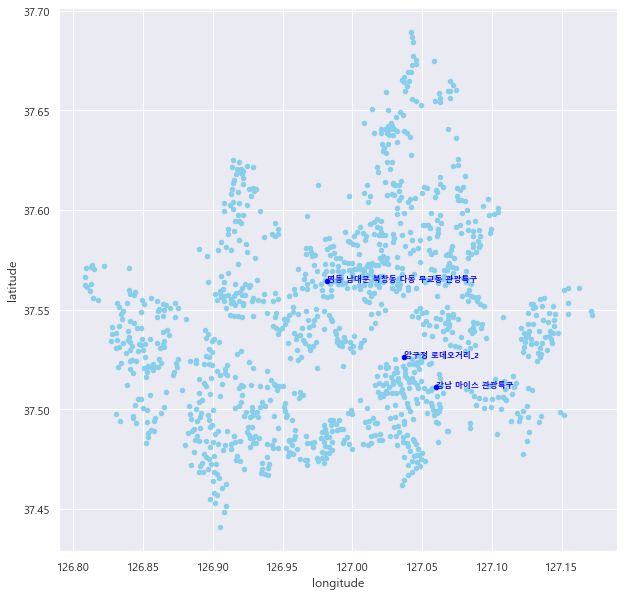

In [67]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[2].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
for name,long,lat in zip(label[2]['Commercial_Area_Name'],label[2]['longitude'],label[2]['latitude']):
        plt.text(long, lat, name, color = "blue", fontsize=8, weight='bold')

### label 3
* 점포수 400 이상 600 이하
* 2030의 매출 총 건수와 총 점포 수가 가장 높고, 총 매출 대비 2030의 매출도 가장 높음.
* 유동인구가 가장 많은 지역.
* 압구정역, 가로수길, 홍대

In [69]:
label[3].head(20)

,Commercial_Area_Name,NumofSales,NumofSales_20_30,NumofStores,Total_Popluation,Total_Popluation_Worker,longitude,latitude,cluster,매출_중_2030매출비중,매출_중_직장인가능비중,점포_1개당_2030매출건수,점포_1개당_직장인가능매출건수,점포_1개당_2030매출비중,점포_1개당_직장인가능매출비중,직장인구_생활인구
4,잠실 관광특구,753573,464046,121,6358907,29779,127.115275,37.516476,3,0.615794,0.039517,3835.090909,246.107438,0.005089,0.000327,0.004683
29,서울중앙시장,783592,487867,205,17062078,25219,127.019639,37.566960,3,0.622603,0.032184,2379.839024,123.019512,0.003037,0.000157,0.001478
33,서울 종로구 안국역_2,816110,493288,191,2085448,53254,126.984310,37.577466,3,0.604438,0.065253,2582.659686,278.816754,0.003165,0.000342,0.025536
34,통인시장,693072,385583,159,1839121,28871,126.969908,37.580680,3,0.556339,0.041657,2425.050314,181.578616,0.003499,0.000262,0.015698
35,서울 종로구 종로3가역_3,1533991,807510,277,4677322,33570,126.993921,37.573737,3,0.526411,0.021884,2915.198556,121.191336,0.001900,0.000079,0.007177
48,포스코사거리_1,966855,469873,144,6512210,50900,127.054007,37.508961,3,0.485981,0.052645,3263.006944,353.472222,0.003375,0.000366,0.007816
51,보라매공원,1433625,1007698,134,9191792,5105,126.925042,37.491172,3,0.702902,0.003561,7520.134328,38.097015,0.005246,0.000027,0.000555
52,뱅뱅사거리_2,899591,476561,102,2068224,28955,127.032487,37.491696,3,0.529753,0.032187,4672.166667,283.872549,0.005194,0.000316,0.014000
53,매봉역,1035024,528095,201,11828628,64776,127.043486,37.485106,3,0.510225,0.062584,2627.338308,322.268657,0.002538,0.000311,0.005476
71,종로?청계 관광특구,723493,437248,140,3889871,32935,126.997374,37.569998,3,0.604357,0.045522,3123.200000,235.250000,0.004317,0.000325,0.008467


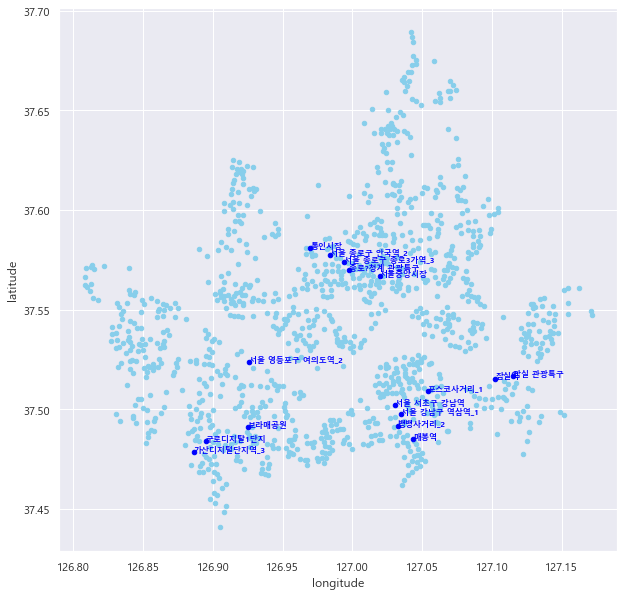

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[3].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
for name,long,lat in zip(label[3]['Commercial_Area_Name'],label[3]['longitude'],label[3]['latitude']):
        plt.text(long, lat, name, color = "blue", fontsize=8, weight='bold')

### label 4
* 점포수 300 이하
* 점포 수를 고려한 2030 매출이 꽤 있는 지역. (2위)
* 유동인구 대비, 직장인구가 가장 많은 지역
* 구디, 가디, 여의도, 시청, 종로, 역삼

In [71]:
label[4].head(20)

,Commercial_Area_Name,NumofSales,NumofSales_20_30,NumofStores,Total_Popluation,Total_Popluation_Worker,longitude,latitude,cluster,매출_중_2030매출비중,매출_중_직장인가능비중,점포_1개당_2030매출건수,점포_1개당_직장인가능매출건수,점포_1개당_2030매출비중,점포_1개당_직장인가능매출비중,직장인구_생활인구
5,영동전통시장,2981219,1906586,564,20241787,88779,127.024181,37.509178,4,0.639532,0.029779,3380.471631,157.409574,0.001134,0.000053,0.004386
37,서교시장,2332755,1708916,448,7360269,14151,126.921539,37.553393,4,0.732574,0.006066,3814.544643,31.587054,0.001635,0.000014,0.001923


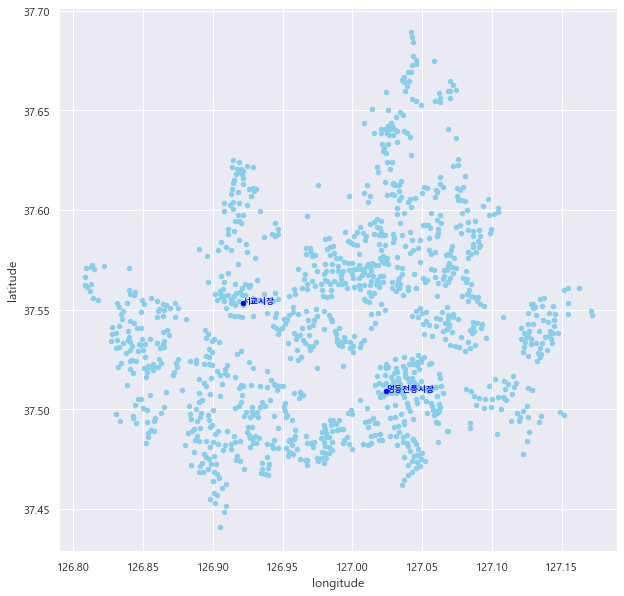

In [72]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
label[4].plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
for name,long,lat in zip(label[4]['Commercial_Area_Name'],label[4]['longitude'],label[4]['latitude']):
        plt.text(long, lat, name, color = "blue", fontsize=8, weight='bold')

# -----------------------------------------